# Digit Recognizer
 * For more information and datasets: https://www.kaggle.com/competitions/digit-recognizer/leaderboard#

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [2]:
train_df = pd.read_csv('/content/drive/MyDrive/Data_Science/digit-recognizer/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Data_Science/digit-recognizer/test.csv')

In [3]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Split label from the dataset
labels = train_df['label']
img = train_df.drop('label', axis=1)

In [5]:
# Reshape the data set into figures.
img = np.asarray(img).reshape([len(img), 28, 28, 1])
labels = np.asarray(labels).reshape([len(img), 1]) # Reshape labels for compatibility

In [6]:
img.shape, labels.shape

((42000, 28, 28, 1), (42000, 1))

In [7]:
labels[:5]

array([[1],
       [0],
       [1],
       [4],
       [0]])

In [8]:
img[0].shape

(28, 28, 1)

## Data Visualization

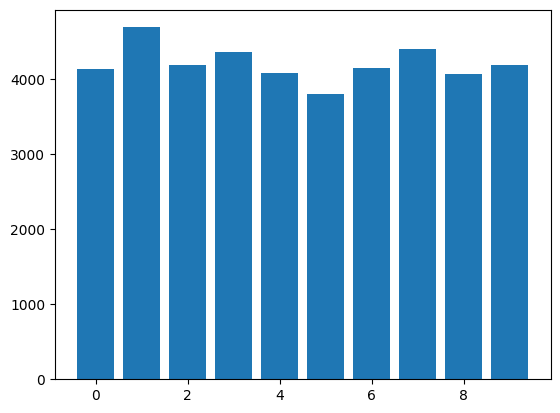

In [9]:
# Plot value counts
x = np.unique(labels, return_counts=True)[0]
y = np.unique(labels, return_counts=True)[1]

plt.bar(x, y);

In [10]:
# Split into val and train datasets
from sklearn.model_selection import train_test_split

train_img, val_img, train_labels, val_labels = train_test_split(img, labels)

In [11]:
print(f"""
  train images shape: {train_img.shape}
  validation images shape: {val_img.shape}
  train labels shape: {train_labels.shape}
  validation labels shape: {val_labels.shape}
""")


  train images shape: (31500, 28, 28, 1)
  validation images shape: (10500, 28, 28, 1)
  train labels shape: (31500, 1)
  validation labels shape: (10500, 1)



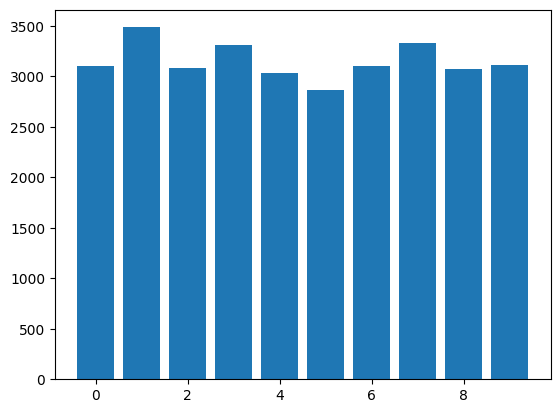

In [12]:
# Plot value counts
x = np.unique(train_labels, return_counts=True)[0]
y = np.unique(train_labels, return_counts=True)[1]

plt.bar(x, y);

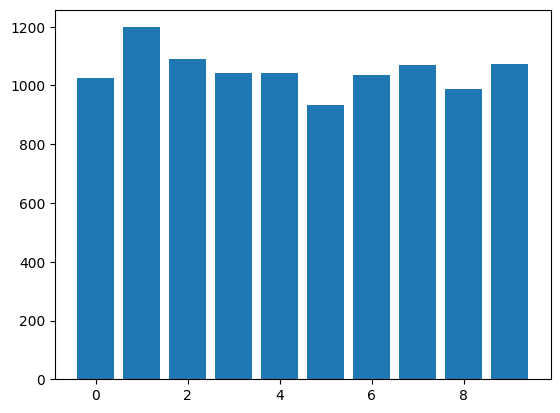

In [13]:
# Plot value counts
x = np.unique(val_labels, return_counts=True)[0]
y = np.unique(val_labels, return_counts=True)[1]

plt.bar(x, y);

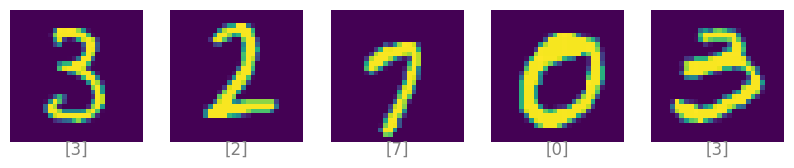

In [14]:
import random

fig = plt.figure(figsize=(10, 10))
for i in range(5):
  random_number = random.randint(1, len(labels-5))
  plt.subplot(5, 5, i+1)
  plt.imshow(img[random_number])
  plt.axis(False)
  plt.title(str(labels[random_number]),y=-0.15, color='grey')

In [15]:
train_img.max()

255

In [16]:
# Creating a dataset to make it easier to feed the data to a tf model

train_set = tf.data.Dataset.from_tensor_slices((train_img, train_labels))
val_set = tf.data.Dataset.from_tensor_slices((val_img, val_labels))

print(train_set)
print(val_set)

<_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>
<_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


In [17]:
def pipeline(tf_data):
  """
  Sheffle and batch data
  """

  # Shuffle data
  tf_data = tf_data.shuffle(100) # Sheffle data
  tf_data = tf_data.batch(32) # Best batch number

  return tf_data

In [18]:
train_set = pipeline(train_set)
val_set = pipeline(val_set)

## Modelling Experiments

### Creating callbacks and evaluation function

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=3)

In [20]:
from tensorflow.keras import layers
NUM_CLASSES = len(np.unique(train_labels))
SHAPE = (28, 28, 1)

# Augmentation model
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.Rescaling(1./255)
])

In [21]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Create function to evaluate model
def evaluate_model(model, X_val, y_val):
  """
  Calculates a model accuracy, precision, recall and f1-score of a classification model

  Return:
    Predictions sample, a dictionary with accuracy, precision, recall and f1-score
  """
  # Get class names
  class_names = np.unique(y_val)

  # Get model predicitions
  y_preds = np.argmax(model.predict(X_val), axis=1)
  print(f"Prediction sample: {y_preds[:5]}\n")

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_val, y_preds)

  # Calculate model precision, recall and f1-score
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_val, y_preds, average="weighted")



  # Create dictionary
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1-score": model_f1}

  return model_results

### Model 0: Baseline Tensorflow example in image classification

In [22]:
# Create Model 0
inputs = layers.Input(shape=SHAPE, name="input_layer")
x = data_augmentation(inputs)
x = layers.Conv2D(32, 3, activation="relu", name="Conv_2D_Layer")(x)
x = layers.MaxPooling2D(name="Max_Pooling_2D_layer")(x)
x = layers.Flatten(name="Flatten_Layer")(x)
x = layers.Dense(128, activation="relu", name="Dense_Layer")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="Output_Layer")(x)


model_0 = tf.keras.Model(inputs, outputs, name="baseline_model")

# Compile Model
model_0.compile(loss="SparseCategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get model summary
model_0.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         0         
                                                                 
 Conv_2D_Layer (Conv2D)      (None, 26, 26, 32)        320       
                                                                 
 Max_Pooling_2D_layer (MaxP  (None, 13, 13, 32)        0         
 ooling2D)                                                       
                                                                 
 Flatten_Layer (Flatten)     (None, 5408)              0         
                                                                 
 Dense_Layer (Dense)         (None, 128)               692352    
                                                    

In [23]:
history_baseline = model_0.fit(train_set,
                               epochs=100,
                               validation_data=val_set,
                               callbacks=[early_stopping],
                               verbose=0)

In [24]:
model_0_score = evaluate_model(model=model_0,
                               X_val=val_img,
                               y_val=val_labels)
model_0_score

329/329 [==============================] - 1s 2ms/step
Prediction sample: [6 9 5 7 9]



{'accuracy': 0.9417142857142857,
 'precision': 0.9431087406375125,
 'recall': 0.9417142857142857,
 'f1-score': 0.9417763488208827}

In [25]:
model_0.evaluate(val_set)

329/329 [==============================] - 1s 3ms/step - loss: 0.1942 - accuracy: 0.9417


[0.19415441155433655, 0.9417142868041992]

In [26]:
# Plot loss curves
def plot_curves(history):
  """
  Returns separate plots for loss, accuracy, val_loss and val_accuracy
  """

  loss = history.history["loss"]
  acc = history.history["accuracy"]
  val_loss = history.history["val_loss"]
  val_acc = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training loss")
  plt.plot(epochs, val_loss, label="validation loss")
  plt.title("loss")
  plt.xlabel("epochs"),
  plt.legend()

  plt.figure()

  # Plot accuracy
  plt.plot(epochs, acc, label="training accuracy")
  plt.plot(epochs, val_acc, label="validation accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs"),
  plt.legend()


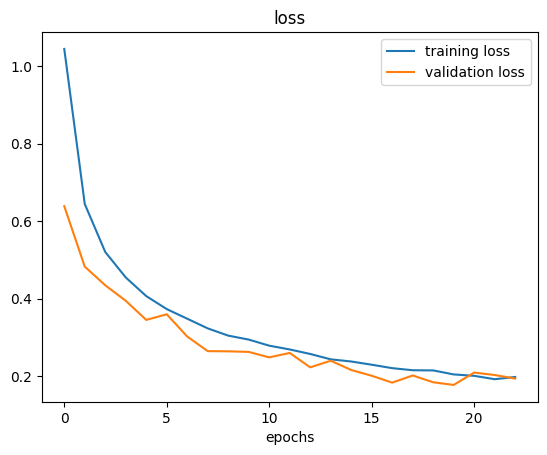

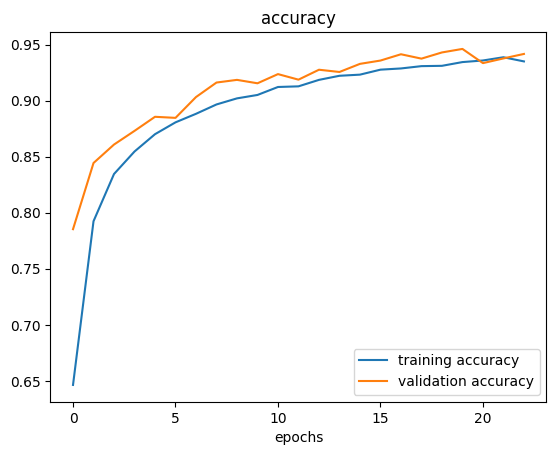

In [27]:
plot_curves(history_baseline)

### Model 1: Increasing Model 0 complexity

In [28]:
# Create Model
inputs = layers.Input(shape=SHAPE, name="input_layer")
x = data_augmentation(inputs)
x = layers.Conv2D(128, 5, activation="relu", name="Conv_2D_Layer")(x)
x = layers.MaxPooling2D(name="Max_Pooling_2D_layer")(x)
x = layers.Dense(128, activation="relu", name="Dense_Layer")(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="Output_Layer")(x)


model_1 = tf.keras.Model(inputs, outputs, name="model_1")

# Compile Model
model_1.compile(loss="SparseCategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         0         
                                                                 
 Conv_2D_Layer (Conv2D)      (None, 24, 24, 128)       3328      
                                                                 
 Max_Pooling_2D_layer (MaxP  (None, 12, 12, 128)       0         
 ooling2D)                                                       
                                                                 
 Dense_Layer (Dense)         (None, 12, 12, 128)       16512     
                                                                 
 global_average_pooling2d (  (None, 128)               0         
 GlobalAveragePooling2D)                                   

In [29]:
history_model_1 = model_1.fit(train_set,
                               epochs=100,
                               validation_data=val_set,
                               callbacks=[early_stopping],
                               verbose=0)

In [30]:
model_1_score = evaluate_model(model=model_1,
                               X_val=val_img,
                               y_val=val_labels)
model_1_score

329/329 [==============================] - 1s 2ms/step
Prediction sample: [9 2 3 4 9]



{'accuracy': 0.6247619047619047,
 'precision': 0.6425470292488453,
 'recall': 0.6247619047619047,
 'f1-score': 0.5955069303329883}

In [31]:
model_1.evaluate(val_set)

329/329 [==============================] - 1s 4ms/step - loss: 1.1602 - accuracy: 0.6248


[1.1601510047912598, 0.6247618794441223]

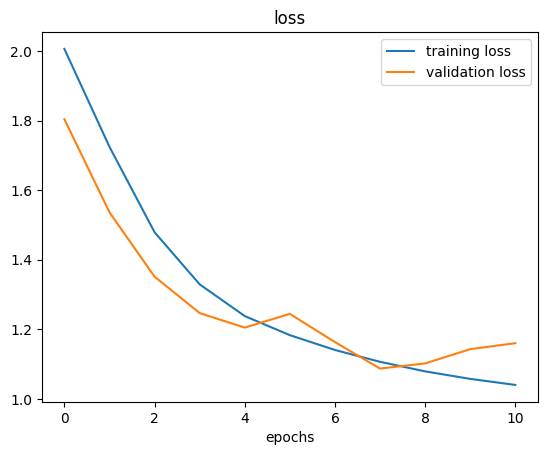

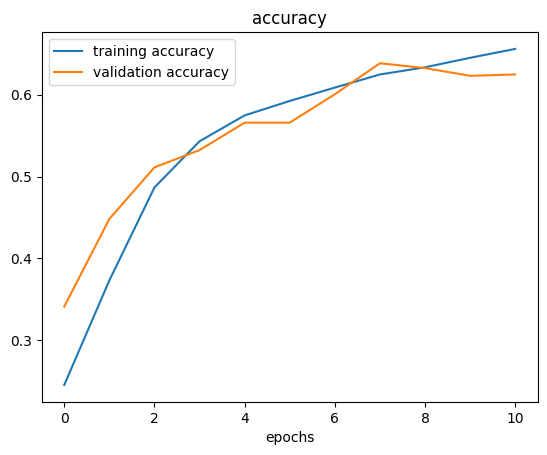

In [32]:
plot_curves(history_model_1)

### Model 2: Add Layers

In [33]:
# Create Model
inputs = layers.Input(shape=SHAPE, name="input_layer")
x = data_augmentation(inputs)
x = layers.Dropout(0.2)(x) # Dropout layer to prevent overfitting
x = layers.Conv2D(128, 5, activation="relu", name="Conv_2D_Layer")(x)
x = layers.MaxPooling2D(name="Max_Pooling_2D_layer")(x)
x = layers.Conv2D(128, 5, activation="relu", name="Conve_2D_Layer_2")(x)
x = layers.MaxPooling2D(name="Max_Pooling_2D_Layer_2")(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="Output_Layer")(x)


model_2 = tf.keras.Model(inputs, outputs, name="model_2")

# Compile Model
model_2.compile(loss="SparseCategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get summary
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 1)         0         
                                                                 
 Conv_2D_Layer (Conv2D)      (None, 24, 24, 128)       3328      
                                                                 
 Max_Pooling_2D_layer (MaxP  (None, 12, 12, 128)       0         
 ooling2D)                                                       
                                                                 
 Conve_2D_Layer_2 (Conv2D)   (None, 8, 8, 128)         409728    
                                                           

In [34]:
history_model_2 = model_2.fit(train_set,
                               epochs=100,
                               validation_data=val_set,
                               callbacks=[early_stopping],
                               verbose=0)

In [35]:
model_2_score = evaluate_model(model=model_2,
                               X_val=val_img,
                               y_val=val_labels)
model_2_score

329/329 [==============================] - 1s 2ms/step
Prediction sample: [6 9 5 7 9]



{'accuracy': 0.8926666666666667,
 'precision': 0.8966132036667744,
 'recall': 0.8926666666666667,
 'f1-score': 0.8924755305430156}

In [36]:
model_2.evaluate(val_set)

329/329 [==============================] - 1s 4ms/step - loss: 0.3276 - accuracy: 0.8927


[0.3276001811027527, 0.8926666378974915]

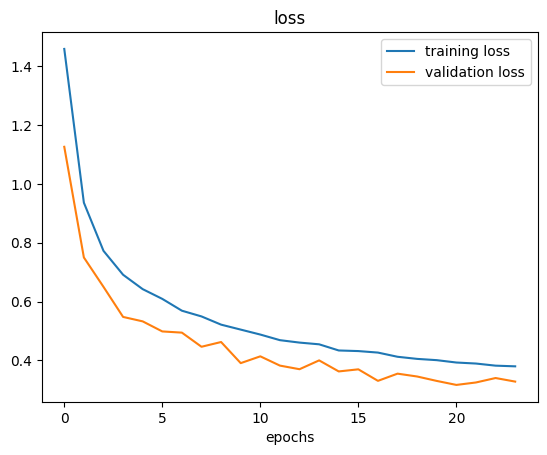

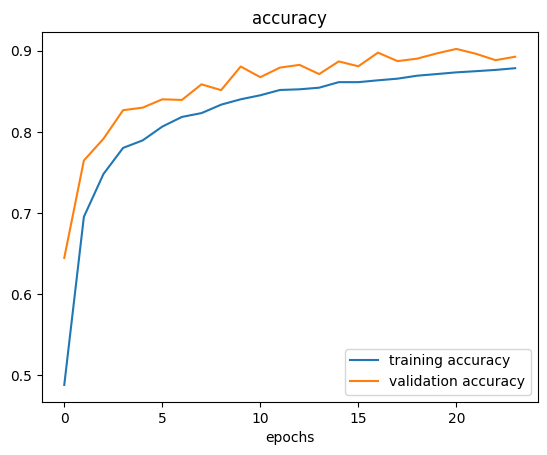

In [37]:
plot_curves(history_model_2)

### Model 3: Two Conv2D loops

In [38]:
# Create model
inputs = layers.Input(shape=SHAPE, name="input")
# First loop
x = layers.Conv2D(32, 5, activation='relu', name="Conv2D")(inputs)
x = layers.MaxPooling2D(name="Max_Pooling")(x)
# Second loop
x = layers.Conv2D(64, 5, activation='relu', name="Conv2D_2")(x)
x = layers.MaxPooling2D(name="Max_Pooling_2")(x)
# Max Pooling
x = layers.MaxPooling2D(name="Max_Pooling_3")(x)
# Flatten
x = layers.Flatten(name="Flatten_Layer")(x)
# Dense Layers + output
x = layers.Dense(128, activation="relu", name="Dense_Layer")(x)
x = layers.Dense(32, activation="relu", name="Dense_Layer_2")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="output")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3")

# Compile model
model_3.compile(loss="SparseCategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get summary
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 Conv2D (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 Max_Pooling (MaxPooling2D)  (None, 12, 12, 32)        0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 Max_Pooling_2 (MaxPooling2  (None, 4, 4, 64)          0         
 D)                                                              
                                                                 
 Max_Pooling_3 (MaxPooling2  (None, 2, 2, 64)          0         
 D)                                                        

In [39]:
history_model_3 = model_3.fit(train_set,
                               epochs=100,
                               validation_data=val_set,
                               callbacks=[early_stopping],
                               verbose=0)

In [40]:
model_3_score = evaluate_model(model=model_3,
                               X_val=val_img,
                               y_val=val_labels)
model_3_score

329/329 [==============================] - 1s 2ms/step
Prediction sample: [6 9 5 4 9]



{'accuracy': 0.983904761904762,
 'precision': 0.9839933391342285,
 'recall': 0.983904761904762,
 'f1-score': 0.9838977910097361}

In [41]:
model_3.evaluate(val_set)

329/329 [==============================] - 1s 3ms/step - loss: 0.0750 - accuracy: 0.9839


[0.07498064637184143, 0.9839047789573669]

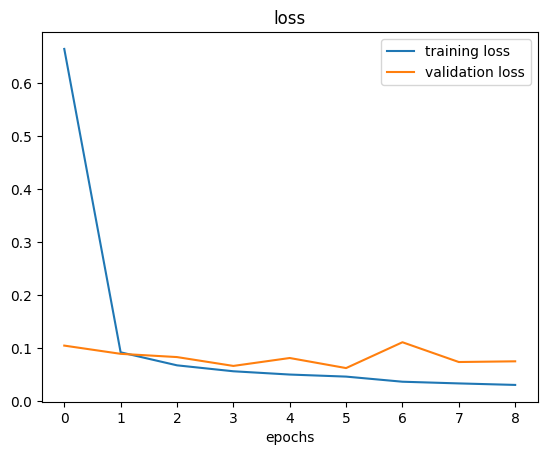

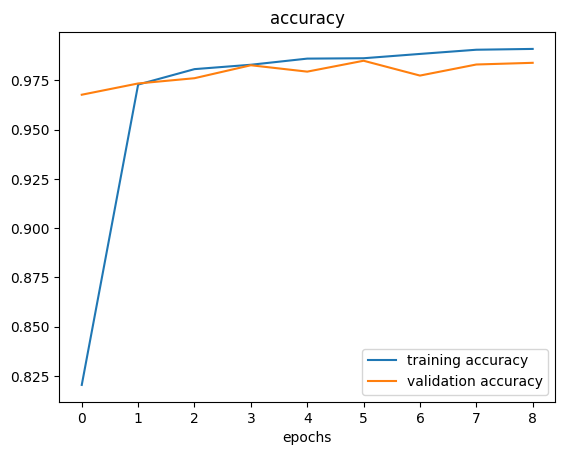

In [42]:
plot_curves(history_model_3)

### Model 4: Same as model 3 but with data augmentation

In [43]:
# Create model
inputs = layers.Input(shape=SHAPE, name="input")
# Data augmentation
x = data_augmentation(inputs)
# First loop
x = layers.Conv2D(32, 5, activation='relu', name="Conv2D")(x)
x = layers.MaxPooling2D(name="Max_Pooling")(x)
# Second loop
x = layers.Conv2D(64, 5, activation='relu', name="Conv2D_2")(x)
x = layers.MaxPooling2D(name="Max_Pooling_2")(x)
# Max Pooling
x = layers.MaxPooling2D(name="Max_Pooling_3")(x)
# Flatten
x = layers.Flatten(name="Flatten_Layer")(x)
# Dense Layers + output
x = layers.Dense(128, activation="relu", name="Dense_Layer")(x)
x = layers.Dense(32, activation="relu", name="Dense_Layer_2")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="output")(x)

model_4 = tf.keras.Model(inputs, outputs, name="model_4")

# Compile model
model_4.compile(loss="SparseCategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get summary
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         0         
                                                                 
 Conv2D (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 Max_Pooling (MaxPooling2D)  (None, 12, 12, 32)        0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 Max_Pooling_2 (MaxPooling2  (None, 4, 4, 64)          0         
 D)                                                              
                                                           

In [44]:
history_model_4 = model_4.fit(train_set,
                               epochs=100,
                               validation_data=val_set,
                               callbacks=[early_stopping],
                               verbose=0)

In [45]:
model_4_score = evaluate_model(model=model_4,
                               X_val=val_img,
                               y_val=val_labels)
model_4_score

329/329 [==============================] - 1s 2ms/step
Prediction sample: [6 9 5 4 9]



{'accuracy': 0.9353333333333333,
 'precision': 0.9367149463869641,
 'recall': 0.9353333333333333,
 'f1-score': 0.9349282298600607}

In [46]:
model_4.evaluate(val_set)

329/329 [==============================] - 1s 3ms/step - loss: 0.2012 - accuracy: 0.9353


[0.20123203098773956, 0.9353333115577698]

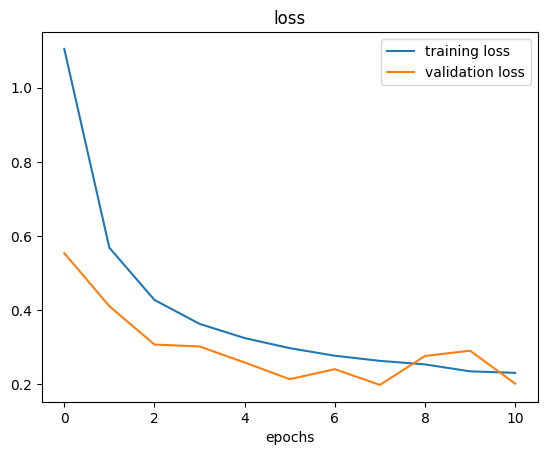

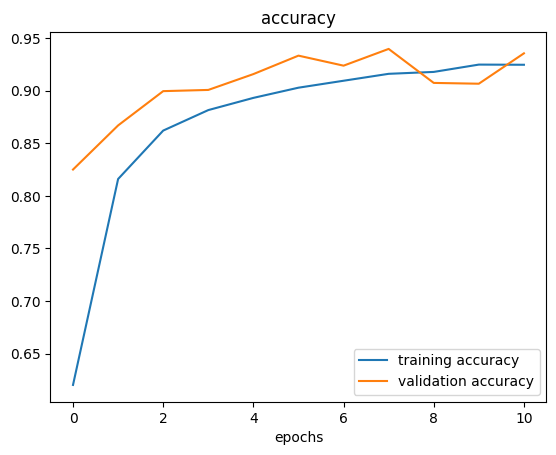

In [47]:
plot_curves(history_model_4)

### Model 5: Same as model 3 but with kernel_size=3

In [48]:
# Create model
inputs = layers.Input(shape=SHAPE, name="input")
# First loop
x = layers.Conv2D(32, 3, activation='relu', name="Conv2D")(inputs)
x = layers.MaxPooling2D(name="Max_Pooling")(x)
# Second loop
x = layers.Conv2D(64, 3, activation='relu', name="Conv2D_2")(x)
x = layers.MaxPooling2D(name="Max_Pooling_2")(x)
# Max Pooling
x = layers.MaxPooling2D(name="Max_Pooling_3")(x)
# Flatten
x = layers.Flatten(name="Flatten_Layer")(x)
# Dense Layers + output
x = layers.Dense(128, activation="relu", name="Dense_Layer")(x)
x = layers.Dense(32, activation="relu", name="Dense_Layer_2")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="output")(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5")

# Compile model
model_5.compile(loss="SparseCategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get model summary
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 Conv2D (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 Max_Pooling (MaxPooling2D)  (None, 13, 13, 32)        0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 Max_Pooling_2 (MaxPooling2  (None, 5, 5, 64)          0         
 D)                                                              
                                                                 
 Max_Pooling_3 (MaxPooling2  (None, 2, 2, 64)          0         
 D)                                                        

In [49]:
history_model_5 = model_5.fit(train_set,
                               epochs=100,
                               validation_data=val_set,
                               callbacks=[early_stopping],
                               verbose=0)

In [50]:
model_5_score = evaluate_model(model=model_5,
                               X_val=val_img,
                               y_val=val_labels)
model_5_score

329/329 [==============================] - 1s 3ms/step
Prediction sample: [6 9 5 4 9]



{'accuracy': 0.979047619047619,
 'precision': 0.9790784060397474,
 'recall': 0.979047619047619,
 'f1-score': 0.9790351051499677}

In [51]:
model_5.evaluate(val_set)

329/329 [==============================] - 1s 3ms/step - loss: 0.0966 - accuracy: 0.9790


[0.09661861509084702, 0.9790475964546204]

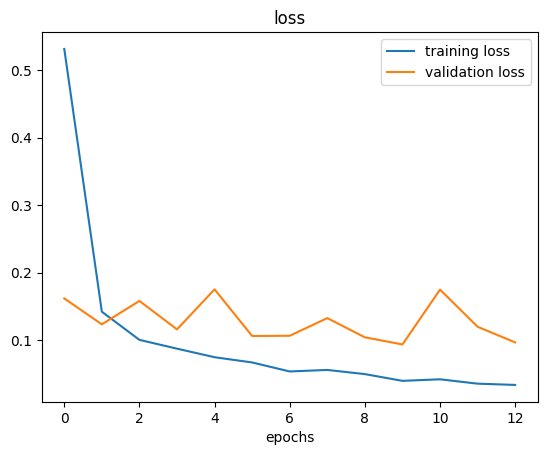

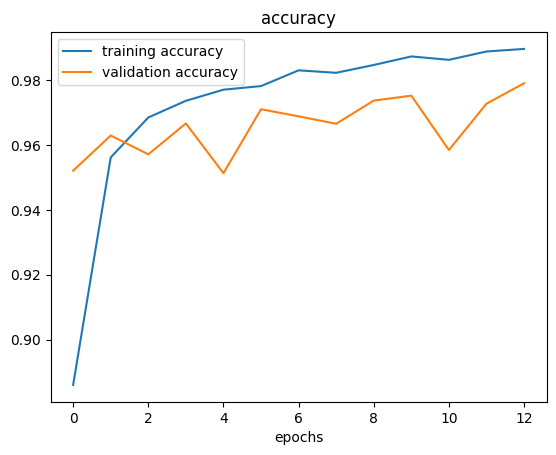

In [52]:
plot_curves(history_model_5)

## Compare and evaluate models

### Comparing model results

In [53]:
models_results = pd.DataFrame({"baseline": model_0_score,
                               "model_1": model_1_score,
                               "model_2": model_2_score,
                               "model_3": model_3_score,
                               "model_4": model_4_score,
                               "model_5": model_5_score})

models_results = models_results.transpose()
models_results

,accuracy,precision,recall,f1-score
baseline,0.941714,0.943109,0.941714,0.941776
model_1,0.624762,0.642547,0.624762,0.595507
model_2,0.892667,0.896613,0.892667,0.892476
model_3,0.983905,0.983993,0.983905,0.983898
model_4,0.935333,0.936715,0.935333,0.934928
model_5,0.979048,0.979078,0.979048,0.979035


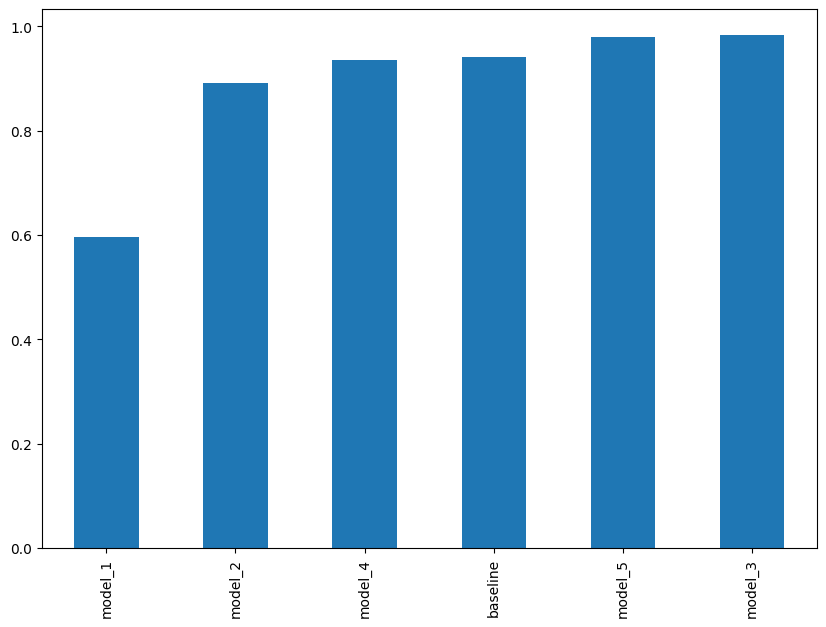

In [54]:
models_results.sort_values("f1-score", ascending=True)["f1-score"].plot(kind="bar", figsize=(10, 7));

### Confusion Matrix

In [55]:
y_pred_probs = model_3.predict(val_img)
y_pred_probs[5], y_pred_probs.shape

329/329 [==============================] - 1s 2ms/step


(array([3.3838210e-15, 9.2700305e-13, 9.5486685e-10, 4.2065957e-14,
        1.0000000e+00, 4.9536760e-19, 1.2678669e-21, 1.4497608e-12,
        4.6169820e-19, 7.3694086e-11], dtype=float32),
 (10500, 10))

In [56]:
y_preds = tf.argmax(y_pred_probs, axis=1)
y_preds[5], y_preds.shape

(<tf.Tensor: shape=(), dtype=int64, numpy=4>, TensorShape([10500]))

In [57]:
# Create and plot a confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):
  """
  Plot a confusion matrix
  """
  # create a confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1) # normalize confusion matrix
  n_classes = cm.shape[0]

  # Let's prettify
  fig, ax = plt.subplots(figsize=figsize)
  # Create a matrix plot
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  # Set labels
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted Label",
         ylabel="True Label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

 # Set x-axis labels to bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Adjust label size
  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)

  # Set threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size)


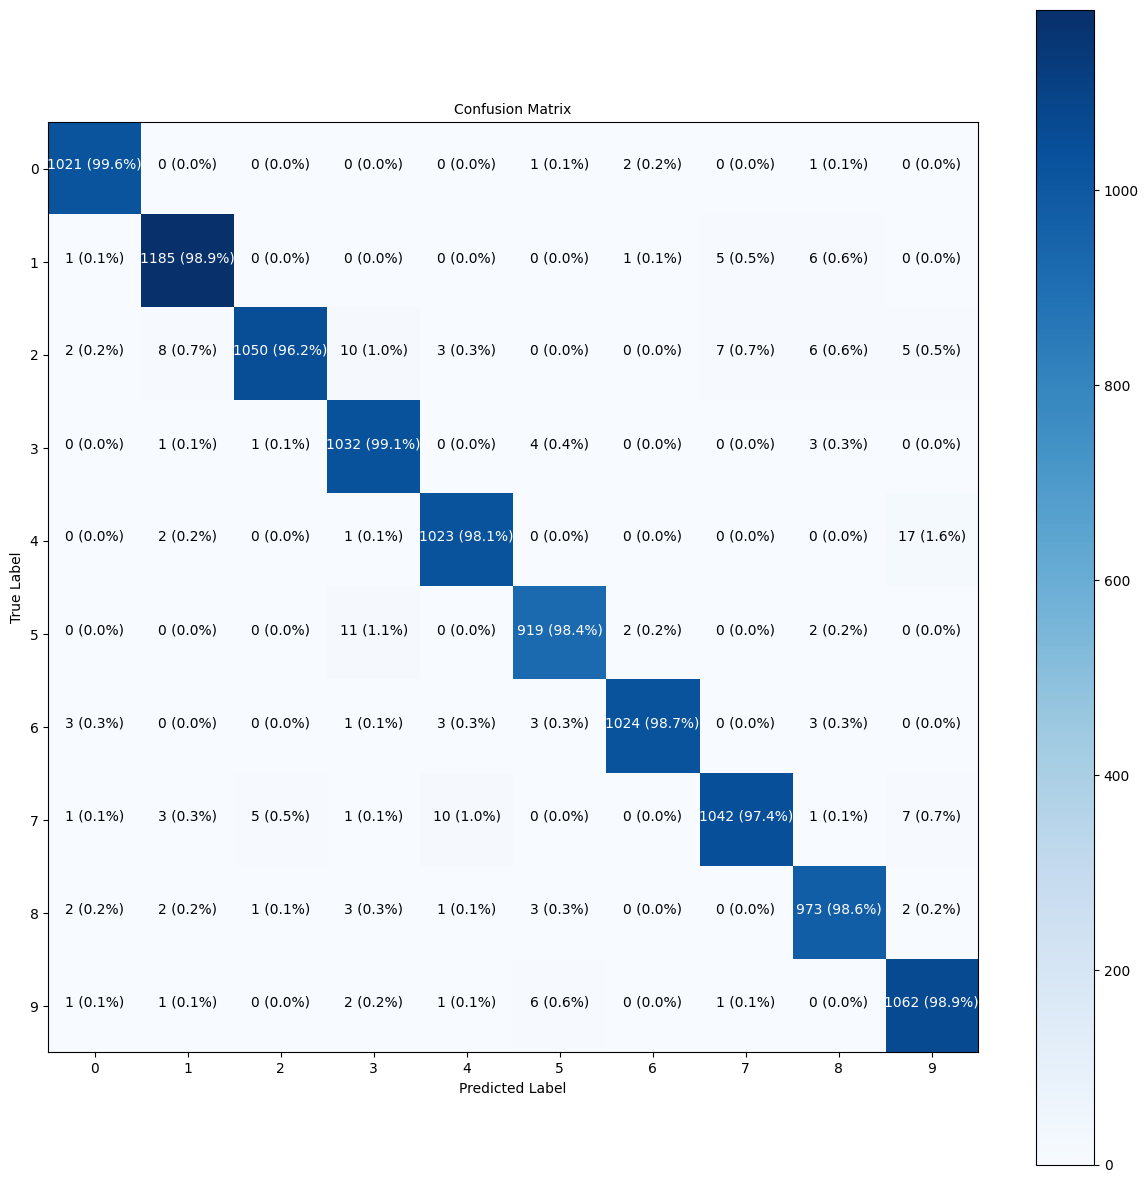

In [58]:
make_confusion_matrix(y_true=val_labels,
                      y_pred=y_preds,
                      figsize=(15, 15),
                      text_size=10)

### Prepare and predict test dataset

In [61]:
train_img.shape

(31500, 28, 28, 1)

In [59]:
test_df.shape

(28000, 784)

In [63]:
test_df = np.asarray(test_df).reshape([len(test_df), 28, 28, 1])
test_df.shape

(28000, 28, 28, 1)

In [64]:
test_pred_probs = model_3.predict(test_df)
test_pred_probs[2]

875/875 [==============================] - 4s 4ms/step


array([[4.20473292e-12, 7.43011624e-11, 9.99998569e-01, ...,
        3.50119706e-07, 7.10772885e-10, 4.07187201e-11],
       [9.99985218e-01, 1.49837174e-12, 1.13438787e-08, ...,
        4.44686077e-17, 7.20942523e-07, 6.59821126e-07],
       [3.95440896e-13, 1.31195478e-12, 2.90366932e-11, ...,
        4.29317845e-15, 1.11311735e-07, 9.99999881e-01],
       ...,
       [0.00000000e+00, 1.27358618e-11, 1.19524058e-17, ...,
        6.19100034e-16, 2.53834588e-19, 5.14451695e-23],
       [2.47459414e-10, 7.78725251e-10, 1.50202979e-08, ...,
        1.50167140e-12, 4.48174404e-08, 9.99995351e-01],
       [4.13497621e-18, 2.83293954e-19, 1.00000000e+00, ...,
        1.50868044e-12, 2.96893386e-16, 3.66969218e-19]], dtype=float32)

In [65]:
test_pred = tf.argmax(test_pred_probs, axis=1)
test_pred, test_pred.shape

(<tf.Tensor: shape=(28000,), dtype=int64, numpy=array([2, 0, 9, ..., 3, 9, 2])>,
 TensorShape([28000]))

In [80]:
imageid = [i for i in range(1, len(test_df)+1) ]
imageid[0], imageid[-1], len(imageid)

(1, 28000, 28000)

### Create Submission File with the format:
* ImageId - Label

In [87]:
submission_file = pd.DataFrame({"ImageId": imageid,
                               "Label": test_pred})

submission_file

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [92]:
submission_file.to_csv("submission_file.csv", index=False)

In [93]:
submission_review = pd.read_csv("submission_file.csv")
submission_review.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
